In [ ]:
!pip install keras-ocr==0.8.7
!pip install imutils


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 2.8 MB/s 
     |████████████████████████████████| 9.5 MB 10.3 MB/s 
     |████████████████████████████████| 944 kB 44.4 MB/s 
     |████████████████████████████████| 604 kB 47.8 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.7-py3-none-any.whl size=43748 sha256=71725c46707489a58055713b864202acd8ef88482329e457b3ebc665d26ecfb4
  Stored in directory: /root/.cache/pip/wheels/e4/e4/f3/05528293e01d7fa089343d5a5fd63dd07d79f57103fe9fc159
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=a22a7b6106c1b0fb386a5f7f6eeb4297ede2841730f3fdff530c5472f724442e
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built keras-ocr validators
Looking in indexes: https://pypi.org/simple, h

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras_ocr
from matplotlib import pyplot as plt
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression


In [1]:
net = cv2.dnn.readNet("/content/drive/MyDrive//test.pb")
pipeline = keras_ocr.pipeline.Pipeline()

NameError: ignored

In [ ]:
args = {"image":"/content/drive/MyDrive/ocr project/monk/page_1.jpg", "east":"frozen_east_text_detection.pb", "min_confidence":0.5, "width":960, "height":1280}
# load the pre-trained EAST model for text detection 


In [ ]:
image = cv2.imread(args['image'])
image.shape

(670, 522, 3)

In [ ]:
#@title image reshape
#Give location of the image to be read.
image = cv2.imread(args['image'])

#Saving a original image and shape
orig = image.copy()
(origH, origW) = image.shape[:2]

# set the new height and width to default 320 by using args #dictionary.  
(newW, newH) = (args["width"], args["height"])

#Calculate the ratio between original and new image for both height and weight. 
#This ratio will be used to translate bounding box location on the original image. 
rW = origW / float(newW)
rH = origH / float(newH)

# resize the original image to new dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# construct a blob from the image to forward pass it to EAST model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)


In [ ]:
#@title layers, bounding box, confidence
# The following two layer need to pulled from EAST model for achieving this. 
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
  
#Forward pass the blob from the image to get the desired output layers
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

# Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# loop over rows
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# loop over the number of columns
		for i in range(0, numC):
			if scoresData[i] < args["min_confidence"]:
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# extracting the rotation angle for the prediction and computing the sine and cosine
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# using the geo volume to get the dimensions of the bounding box
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# compute start and end for the text pred bbox
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# return bounding boxes and associated confidence_val
	return (boxes, confidence_val)

In [ ]:
#@title non-max supression
# Find predictions and  apply non-maxima suppression
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

##Text Detection and Recognition 

# initialize the list of results
results = []
images=[]
# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
  startX = int(startX * rW)
  startY = int(startY * rH)
  endX = int(endX * rW)
  endY = int(endY * rH)
  #extract the region of interest
  r = orig[startY:endY, startX:endX]
  images.append(r)
  # append bbox coordinate and associated text to the list of results 
  results.append((startX, startY, endX, endY))

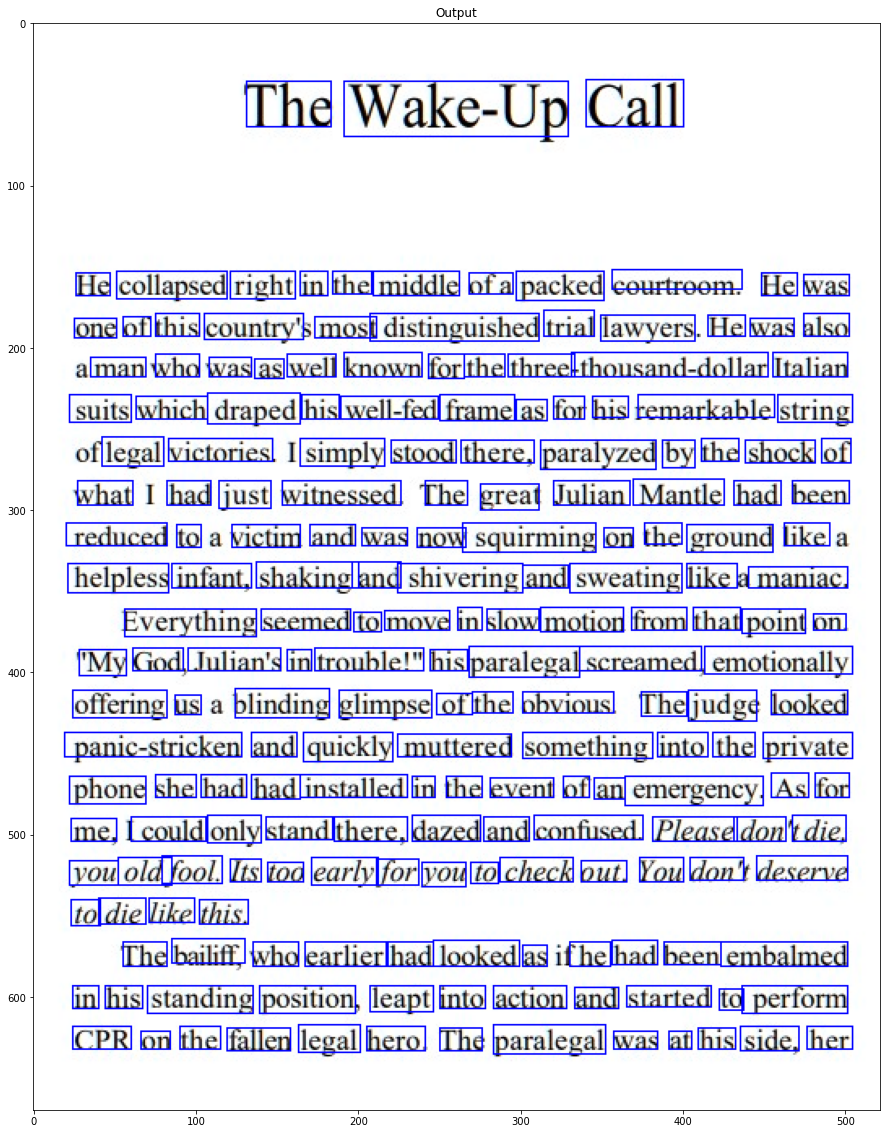

In [ ]:
#@title plots
orig_image = orig.copy()

# Moving over the results and display on the image
for (start_X, start_Y, end_X, end_Y) in results:
	# display the text detected by Tesseract
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 1)
	
plt.figure(figsize=(20, 20))
plt.imshow(orig_image)
plt.title('Output')
plt.savefig("output_1.png")
plt.show()

In [ ]:
prediction_groups = pipeline.recognize(images)

In [ ]:
len(prediction_groups), len(results)

(202, 202)

In [ ]:
blackblankimage =  255 *np.ones(shape=[960, 1280, 3], dtype=np.uint8)

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
i=0
image_again = cv2.imread(args['image'])
for pred in prediction_groups:
  for text, box in pred:
    #cv2.putText(orig_image, text, (box[0][0],box[0][1]), font,1,(0,0,255),2,cv2.LINE_AA)
    cv2.putText(blackblankimage, text, (results[i][0], results[i][1]), font,0.5,(0,0,255),1,cv2.LINE_AA)
  i+=1

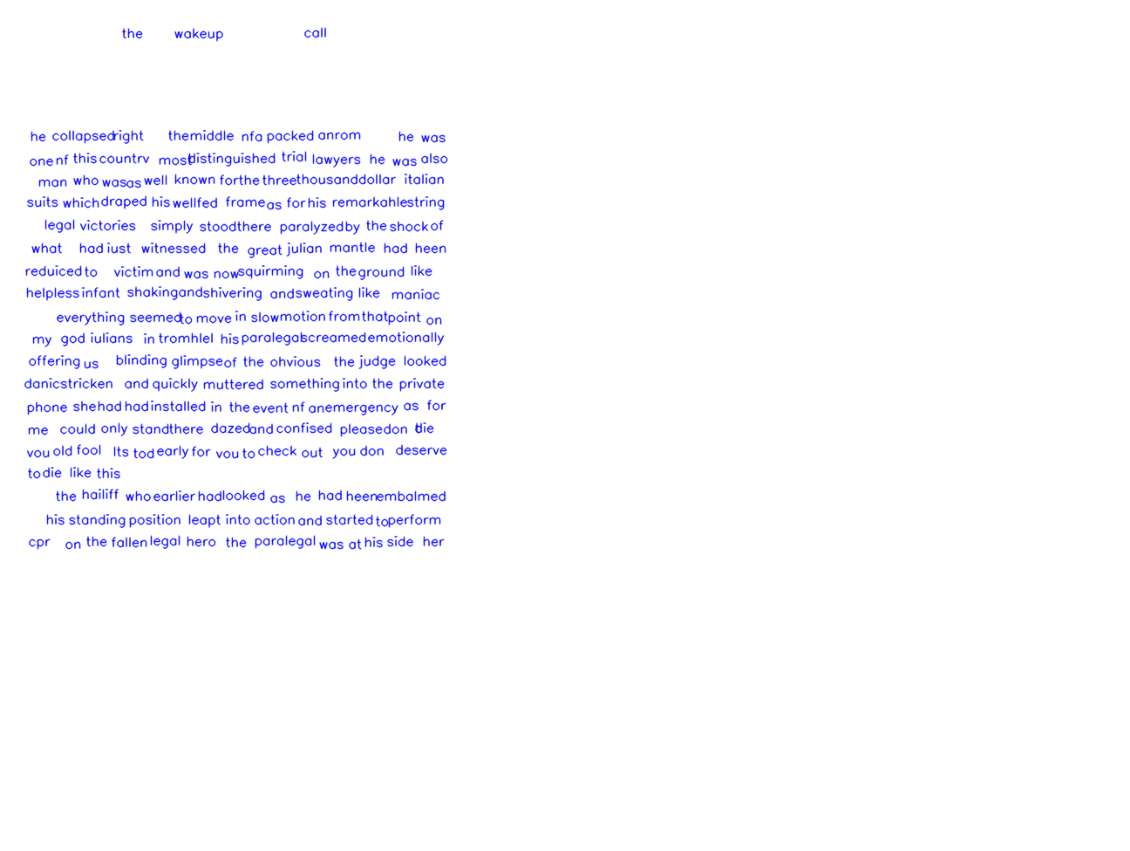

In [ ]:
	
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(blackblankimage)

In [ ]:
i=0
for pred in prediction_groups:
  for text, box in pred:
     cv2.imwrite("/content/drive/MyDrive/ocr project/monk_ocr_data/"+text+".jpg", images[i])
  i+=1

In [ ]:
import os

# folder path
dir_path = r'/content/drive/MyDrive/ocr project/monk_ocr_data/'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 140
